# Sorting

Training a one-layer transformer to sort fixed- or variable-length lists. Problem idea from [200 Open Problems](https://docs.google.com/document/d/1WONBzNqfKIxERejrrPlQMyKqg7jSFW92x5UMXNrMdPo/edit#heading=h.n514s7caro7u). Based on [Neel's video](https://www.youtube.com/watch?v=yo4QvDn-vsU) and accompanying [colab notebook](https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/no-position-experiment/No_Position_Experiment.ipynb#scrollTo=lymHglrXGrFC).

## [ParenTransformer](https://github.com/pranavgade20/wmlb/blob/master/w2d3_instructions.md) Notes

- Positional embeddings are sinusoidal (non-learned).
- Bidirectional attention
- Square MLP layers
- Final Layer Norm
- no dropout
- [BEGIN] and [END] tokens

In [1]:
import random
from typing import Tuple

import circuitsvis as cv
import einops
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import transformer_lens
import transformer_lens.utils as utils
from fancy_einsum import einsum
from torch.utils.data import DataLoader, Dataset
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
)
from transformer_lens.hook_points import (  # Hooking utilities
    HookedRootModule,
    HookPoint,
)

from torchtyping import TensorType as TT, patch_typeguard
from typeguard import typechecked

patch_typeguard()  # use before @typechecked


def total_params(model: nn.Module):
    """
    ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(DEVICE) -> 58634
    """
    
    return sum([param.numel() for name, param in model.named_parameters()])

In [2]:
device = "cuda"

## Model

In [3]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Config:
    seed: int = 0
    d_model: int = 56
    num_heads: int = 1
    n_layers: int = 1
    seq_len: int = 10
    distinct_nums: int = 10
    normalization: Optional[str] = None
    bidirectional: bool = False

    def __post_init__(self):
        assert self.d_model % self.num_heads == 0

In [4]:
def reset_seeds(seed: int):
    print(f"Reset Seeds {seed}")
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    # t.use_deterministic_algorithms(True)

In [5]:
def make_transformer(cfg: Config) -> HookedTransformer:
    """
    seq_len: length of sequence to be sorted. input will be of form [BOS] ... unsorted sequence [MID] ... sorted sequence
    distinct_nums: number of distinct tokens that can appear in sequence (excluding [BOS] and [MID])
    """
    reset_seeds(cfg.seed)
    transformer_cfg = HookedTransformerConfig(
        n_layers=cfg.n_layers,
        d_model=cfg.d_model,
        d_head=cfg.d_model // cfg.num_heads,
        n_ctx=2 * (cfg.seq_len + 1) if not cfg.bidirectional else cfg.seq_len + 2,
        act_fn='relu',
        d_vocab=cfg.distinct_nums+2 if not cfg.bidirectional else cfg.distinct_nums + 3,
        normalization_type=cfg.normalization,
        attn_only=True,
        use_attn_result=True,
        attention_dir='bidirectional' if cfg.bidirectional else 'causal'
    )
    model = HookedTransformer(transformer_cfg)
    return model

In [6]:
cfg = Config(bidirectional=True)
model = make_transformer(cfg)
print(total_params(model))

Reset Seeds 0
14909


In [7]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [8]:
for name, param in model.named_parameters():
    print(name, param.numel())

embed.W_E 728
pos_embed.W_pos 672
blocks.0.attn.W_Q 3136
blocks.0.attn.W_K 3136
blocks.0.attn.W_V 3136
blocks.0.attn.W_O 3136
blocks.0.attn.b_Q 56
blocks.0.attn.b_K 56
blocks.0.attn.b_V 56
blocks.0.attn.b_O 56
unembed.W_U 728
unembed.b_U 13


## Data + Loss

In [9]:
def gen_data(batch_size: int, cfg: Config, gen_random: bool=False):
    if not cfg.bidirectional:
        BOS, MOS = cfg.distinct_nums, cfg.distinct_nums+1
        data = t.zeros((batch_size, 2*cfg.seq_len + 2), dtype=t.long)

        if not gen_random:
            unsorted_seqs=[]
            for _ in range(batch_size):
                good=[]
                while good==[]:
                    p=random.random()
                    good=[t for t in range(cfg.distinct_nums) if random.random()>p]
                if random.random()<1/3.:
                    low=random.randint(0,cfg.distinct_nums-1)
                    high=random.randint(0,cfg.distinct_nums-1)
                    if low>high: low,high=high,low
                    good=list(range(low,high+1))
                good=t.tensor(good,dtype=t.long)
                # unsorted_seqs=(good[t.randint(0, good.shape[0], (batch_size, cfg.seq_len,))])
                unsorted_seqs.append(good[t.randint(0, good.shape[0], (cfg.seq_len,))])
            unsorted_seqs = t.stack(unsorted_seqs,dim=0)
        else:
            unsorted_seqs = t.randint(0, cfg.distinct_nums, (batch_size, cfg.seq_len))

        sorted_seqs = t.sort(unsorted_seqs, dim=-1).values

        data[:, 0] = BOS
        data[:, 1:cfg.seq_len+1] = unsorted_seqs
        data[:, cfg.seq_len+1] = MOS
        data[:, cfg.seq_len+2:] = sorted_seqs
        return data
    else:
        BOS, EOS, PAD = cfg.distinct_nums, cfg.distinct_nums+1, cfg.distinct_nums+2
        data = t.full((batch_size, cfg.seq_len + 2), PAD, dtype=t.long)
        lengths = t.randint(1, cfg.seq_len + 1, (batch_size,), dtype=t.long)
        if gen_random:
            unsorted_seqs = t.randint(0, cfg.distinct_nums, (batch_size, cfg.seq_len+1))
            for i in range(len(lengths)): # faster way?
                unsorted_seqs[i, lengths[i]] = EOS
                unsorted_seqs[i, lengths[i]+1:] = PAD
        else:
            unsorted_seqs=[]
            for _ in range(batch_size):
                good=[]
                while good==[]:
                    p=random.random()
                    good=[t for t in range(cfg.distinct_nums) if random.random()>p]
                if random.random()<1/3.:
                    low=random.randint(0,cfg.distinct_nums-1)
                    high=random.randint(0,cfg.distinct_nums-1)
                    if low>high: low,high=high,low
                    good=list(range(low,high+1))
                good = t.tensor(good, dtype=t.long)
                desired_len = int(t.randint(size=(),low=1, high=cfg.seq_len+1).item())
                part_of_seq = good[t.randint(0, good.shape[0], (desired_len,))]
                not_part_of_seq = t.full((cfg.seq_len-desired_len,), PAD)
                unsorted_seqs.append(t.cat((part_of_seq, t.tensor([EOS]), not_part_of_seq)))
            unsorted_seqs = t.stack(unsorted_seqs,dim=0)
        sorted_seqs = t.sort(unsorted_seqs, dim=-1).values
        def prepend_bos(x):
            return t.cat((t.full((x.shape[0], 1), BOS), x), dim=1)
        return prepend_bos(unsorted_seqs), prepend_bos(sorted_seqs)


        
sample_data = gen_data(2, Config(seq_len=10, distinct_nums=10, bidirectional=False))
print(sample_data)

tensor([[10,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9],
        [10,  1,  7,  6,  6,  8,  4,  9,  8,  0,  5, 11,  0,  1,  4,  5,  6,  6,
          7,  8,  8,  9]])


In [10]:
sample_data = gen_data(2, Config(seq_len=10, distinct_nums=10, bidirectional=True))
print(sample_data)

(tensor([[10,  2,  3,  4,  2,  1,  0,  2,  4,  1,  2, 11],
        [10,  8,  5,  6,  8,  8,  8,  6,  5, 11, 12, 12]]), tensor([[10,  0,  1,  1,  2,  2,  2,  2,  3,  4,  4, 11],
        [10,  5,  5,  6,  6,  8,  8,  8,  8, 11, 12, 12]]))


In [11]:
@typechecked
def loss_fn(cfg: Config, logits: TT["b", "s", "v"], inputs: TT["b", "s"]):
    """logits: unnormalized"""
    if cfg.bidirectional:
        preds = logits.transpose(1, 2) # b, v, s
        targets = inputs # b, s
        ent = F.cross_entropy(preds, targets, reduction='none')
        assert ent.shape == inputs.shape
        mask = inputs < cfg.distinct_nums
        return (ent * mask).sum() / mask.sum()
    else:
        seq_len = logits.shape[1] // 2 - 1
        preds = logits[:, seq_len+1:-1].transpose(1, 2) # b, v, s
        targets = inputs[:, seq_len+2:] # b, s
        return F.cross_entropy(preds, targets)

def test_unidirectional_loss():
    cfg = Config(bidirectional=False)
    inputs = t.tensor([[3, 2, 1, 4, 1, 2]])
    logits = t.tensor([[
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # log(5)
    logits = t.tensor([[
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 100, 0, 0, 0],
        [0, 0, 100, 0, 0],
        [0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # 0, correct order
    logits = t.tensor([[
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 100, 0, 0],
        [0, 100, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # 100, wrong order

test_unidirectional_loss()

tensor(1.6094)
tensor(0.)
tensor(100.)


In [12]:
def test_bidirectional_loss():
    cfg = Config(bidirectional=True, distinct_nums=3)
    inputs = t.tensor([[3, 2, 1, 4, 5, 5]])
    logits = t.tensor([[
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # log(6)
    logits = t.tensor([[
        [0, 0, 0, 0, 0, 0],
        [0, 100, 0, 0, 0, 0],
        [0, 0, 100, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # 0, correct order
    logits = t.tensor([[
        [0, 0, 0, 0, 0, 0],
        [0, 0, 100, 0, 0, 0],
        [0, 100, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]]).float()
    print(loss_fn(cfg, logits, inputs)) # 100, wrong order

test_bidirectional_loss()

tensor(1.7918)
tensor(100.)
tensor(0.)


## Training

In [13]:
def train(model: HookedTransformer, cfg: Config, batch_size: int=1024, lr: float=1e-3, wd:float = 0.0, num_epochs: int=5000):
    """TODO: adjust parameters?"""
    model.train()

    opt = t.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # TODO: weight decay?
    def make_dataloader():
        while True:
            yield gen_data(batch_size, cfg)
    dataloader = make_dataloader()
    
    losses = []
    for epoch in range(num_epochs):
        opt.zero_grad()
        if not cfg.bidirectional:
            tokens = next(dataloader).to(device)
            logits = model(tokens)
            loss = loss_fn(cfg, logits, tokens)
        else:
            inp_tokens, out_tokens = next(dataloader)
            inp_tokens = inp_tokens.to(device)
            out_tokens = out_tokens.to(device)
            logits = model(inp_tokens)
            loss = loss_fn(cfg, logits, out_tokens)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: {loss.item()}',flush=True)

Note: 1 head transformer stagnates at 0.03 loss.

In [14]:
cfg

Config(seed=0, d_model=56, num_heads=1, n_layers=1, seq_len=10, distinct_nums=10, normalization=None, bidirectional=True)

In [15]:
MODEL_PATH = f"model_{cfg}.pt"

import os

if os.path.exists(MODEL_PATH):
    model = t.load(MODEL_PATH)
    print("Loaded Model")
else:
    model = make_transformer(cfg)
    train(model, cfg)
    t.save(model, MODEL_PATH)
    print(f"Saved Model {MODEL_PATH}")

Loaded Model


In [16]:
def evaluate_acc(cfg: Config, model: HookedTransformer, batch_size: int=4000):
    model.eval()
    with t.inference_mode():
        if not cfg.bidirectional:
            tokens = gen_data(batch_size, cfg).to(device)
            logits = model(tokens)
            output = logits.argmax(dim=-1)
            diff_pos = (output[:, cfg.seq_len+1:-1] != tokens[:, cfg.seq_len+2:])
        else:
            inp, out = gen_data(batch_size, cfg)
            inp = inp.to(device)
            ans = out.to(device)
            logits = model(inp)
            output = logits.argmax(dim=-1)
            diff_pos = (output != ans) * (ans < cfg.distinct_nums)
            tokens = inp
        wrong=0
        for aa,tt,oo in zip(tokens.squeeze(),diff_pos.squeeze(),output.squeeze()):
            if any(tt.tolist()):
                wrong+=1
                print('Input',aa.tolist())
                print('Out',oo.tolist())
        return 1-wrong/batch_size

for _ in range(1):
    print(evaluate_acc(cfg, model))

1.0


In [17]:
def evaluate_loss(cfg: Config, model: HookedTransformer, batch_size: int=4000):
    model.eval()
    with t.inference_mode():
        if not cfg.bidirectional:
            tokens = gen_data(batch_size, cfg).to(device)
            logits = model(tokens)
            return loss_fn(logits, tokens)
        else:
            inp_tokens, out_tokens = gen_data(batch_size, cfg)
            inp_tokens = inp_tokens.to(device)
            out_tokens = out_tokens.to(device)
            logits = model(inp_tokens)
            return loss_fn(cfg, logits, out_tokens)

In [18]:
evaluate_loss(cfg, model)

tensor(0.0003, device='cuda:0')

## Interpretability

In [46]:
from typing import List
import seaborn as sns


def gen_example_from(cfg: Config, seq: List[int]):
    if not cfg.bidirectional:
        BOS, MOS = cfg.seq_len,cfg.seq_len+1
        return t.tensor([BOS] + seq + [MOS] + sorted(seq))
    else:
        BOS, EOS, PAD = cfg.seq_len,cfg.seq_len+1,cfg.seq_len+2
        def to_tensor(seq):
            with t.no_grad():
                ret = t.full((cfg.seq_len+2,), PAD)
                ret[0] = BOS
                ret[1:len(seq)+1] = t.tensor(seq)
                ret[len(seq)+1] = EOS
                return ret.unsqueeze(0)
        return to_tensor(seq), to_tensor(sorted(seq))


def heatmap(logprobs: t.Tensor, clip=99, yticklabels='auto', xticklabels='auto', ax=None, subtract_max: bool=True, prec: int=3):
    if subtract_max:
        logprobs = logprobs-t.amax(logprobs,dim=-1,keepdim=True)
    fmt = f'.{prec}g'
    sns.heatmap(t.clip(logprobs,-clip,clip).cpu(),annot=True,ax=ax,fmt=fmt,yticklabels=yticklabels,xticklabels=xticklabels)

@typechecked
def visualize_output(cfg: Config, sample_data: TT["s"], figsize=(6.4,4.8)):
    with t.inference_mode():
        if not cfg.bidirectional:
            # NOTE: this wasn't updated
            assert sample_data.numel() == 2 * cfg.seq_len + 2
            logprobs = model(sample_data.unsqueeze(0))[0, cfg.seq_len+1:-1]
            plt.title("Output: Log Probabilities")
            heatmap(logprobs)
            plt.show()
            plt.title("Output: Probabilities")
            probs = logprobs.softmax(dim=-1)
            plt.imshow(probs.cpu())
            plt.ylabel("position")
            .xlabel("value")
            .colorbar()
            .show()
        else:
            assert sample_data.numel() == cfg.seq_len + 2
            bad = sample_data >= cfg.distinct_nums
            bad[0] = False
            bad = bad*t.arange(bad.shape[0], 0, -1)
            first_bad = t.argmax(bad)
            logprobs = model(sample_data.unsqueeze(0))[0, 1:first_bad]
            plt.figure(figsize=figsize)
            print("figsize =", figsize)
            plt.title(f"Output: Logits For {list([x.item() for x in sample_data if x < cfg.distinct_nums])}")
            heatmap(logprobs, prec=2)
            plt.ylabel("Position")
            plt.xlabel("Token")



@typechecked
def visualize_output_by_input_pos(cfg: Config, sample_data: TT["s"], dest: int, logits: List[int]):
    """plot logits for each source, weighted by attention.
    
    dest: position you are trying to predict."""
    assert 0 <= dest < cfg.seq_len
    if not cfg.bidirectional:
        dest = cfg.seq_len+1+dest
    else:
        dest = dest+1

    with t.inference_mode():
        out, cache = model.run_with_cache(sample_data.unsqueeze(0))
        # cache: dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_post'])
        
        # cache["resid_post", 0]: 1 x 22 x 25
        tot_out = cache["resid_post", 0][0, dest] @ model.W_U # 22
        attn_dest = cache["pattern", 0, "attn"][0, 0, dest]

        rows = [cache["resid_pre", 0][0, dest] @ model.W_U]
        labels = ["embed"]
        attns = [1.0]
        for i in range(attn_dest.shape[0]):
            tmp = ((cache["resid_pre", 0][0, i] @ model.W_V[0, 0] + model.b_V) @ model.W_O[0, 0]).squeeze()
            rows.append(attn_dest[i] * tmp @ model.W_U)
            labels.append(f"inp_{i}")
            attns.append(attn_dest[i].item())

        rows.append((model.b_O @ model.W_U).squeeze())
        
        rows = t.stack(rows)
        expected = tot_out - tot_out.mean()
        found = t.sum(rows, dim=0) - t.sum(rows, dim=0).mean()
        assert t.allclose(expected, found, 0.1)

        rows = rows[:, logits]
        rows -= rows.mean(dim=-1, keepdim=True)
        print("total logits =", rows.sum(dim=0))
        
        rows = rows[1:12]
        attns = attns[1:12]
        labels = labels[1:12]
        xlabels = ["attn"] + [str(x) for x in logits]

        attns = t.tensor(attns).unsqueeze(-1).to(rows)
        # print("attns =", attns)
        # print(attns.shape, rows.shape)
        # print(attns)
        rows = t.cat((attns, rows), dim=1)
        # print(rows)
        fig, ax = plt.subplots()
        heatmap(rows.cpu(), clip=999, ax=ax, yticklabels=labels, xticklabels=xlabels, subtract_max=False)
        plt.title("Output breakdown")
        plt.tight_layout()

def item_to_string(cfg: Config, x: t.Tensor):
    i = x.item()
    if i < cfg.distinct_nums:
        return str(i)
    if i == cfg.distinct_nums:
        return "BOS"
    if not cfg.bidirectional:
        return "MOS"
    return "EOS" if i == cfg.distinct_nums + 1 else "PAD"


In [20]:
@typechecked
def visualize_attention(cfg: Config, sample_data: TT["s"]):
    if cfg.bidirectional:
        assert sample_data.numel() == cfg.seq_len + 2
    else:
        assert sample_data.numel() == 2 * cfg.seq_len + 2
    with t.inference_mode():
        _, cache = model.run_with_cache(sample_data.unsqueeze(0))
        attention_pattern = cache["pattern", 0, "attn"]
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data], attention=attention_pattern.squeeze(0))
        with open("layer0_attn_patterns.html", "w") as f:
            f.write(str(html))
        return html

def visualize_output_and_attention(cfg, sample_data, figsize=(6.4,4.8)):
    if not cfg.bidirectional:
        print("unsorted_sequence", sample_data[1:cfg.seq_len+1])
        print("sorted_sequence", sample_data[cfg.seq_len+2:])
        visualize_output(cfg, sample_data, figsize=figsize)
        return visualize_attention(cfg, sample_data)
    else:
        inp, out = sample_data
        inp = inp[0]
        out = out[0]
        print(inp, out)
        print("unsorted_sequence", inp[1:cfg.seq_len+1])
        print("sorted_sequence", out[1:cfg.seq_len+1])
        visualize_output(cfg, inp, figsize=figsize)
        return visualize_attention(cfg, inp)
        


def visualize_attention_many(cfg, sample_data):
    with t.inference_mode():
        _, cache = model.run_with_cache(sample_data)
        attention_pattern = t.mean(cache["pattern", 0, "attn"],dim=0)
        html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        return html

tensor([10,  9,  0,  9,  9,  9,  9,  9,  9, 11, 12, 12]) tensor([10,  0,  9,  9,  9,  9,  9,  9,  9, 11, 12, 12])
unsorted_sequence tensor([ 9,  0,  9,  9,  9,  9,  9,  9, 11, 12])
sorted_sequence tensor([ 0,  9,  9,  9,  9,  9,  9,  9, 11, 12])
figsize = (6.4, 4.8)


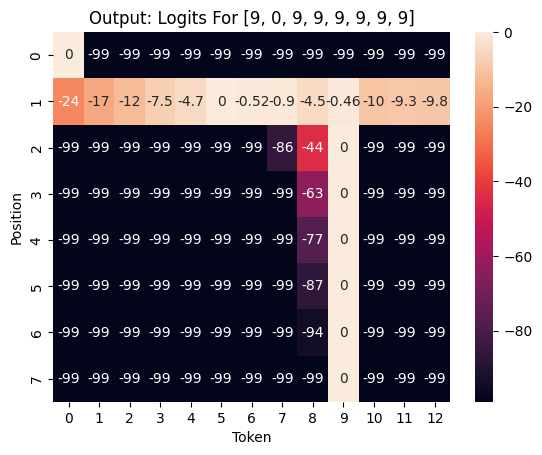

In [47]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [9, 0, 9, 9, 9, 9, 9, 9]))

tensor([10,  9,  9,  9,  9,  8,  9,  9,  9,  9,  8, 11]) tensor([10,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 11])
unsorted_sequence tensor([9, 9, 9, 9, 8, 9, 9, 9, 9, 8])
sorted_sequence tensor([8, 8, 9, 9, 9, 9, 9, 9, 9, 9])
figsize = (6.4, 4.8)


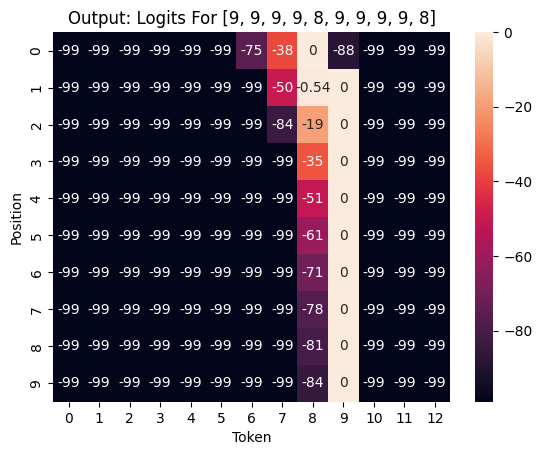

In [48]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [9, 9, 9, 9, 8, 9, 9, 9, 9, 8]))

In [23]:
# 0: BOS
# 11: MOS
# 12...16: 0
# 17...21: 1

### Average Attention

On average, attention is distributed equally among the input sequence. Attention is also paid to the BOS token.

In [24]:
inputs = gen_data(1000, cfg)
if cfg.bidirectional:
    inputs = inputs[0]
visualize_attention_many(cfg, inputs)

### Examples

#### Random

tensor([10,  4,  9,  5,  3,  0,  7,  8,  2,  6,  1, 11]) tensor([10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11])
unsorted_sequence tensor([4, 9, 5, 3, 0, 7, 8, 2, 6, 1])
sorted_sequence tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
figsize = (12.8, 4.8)


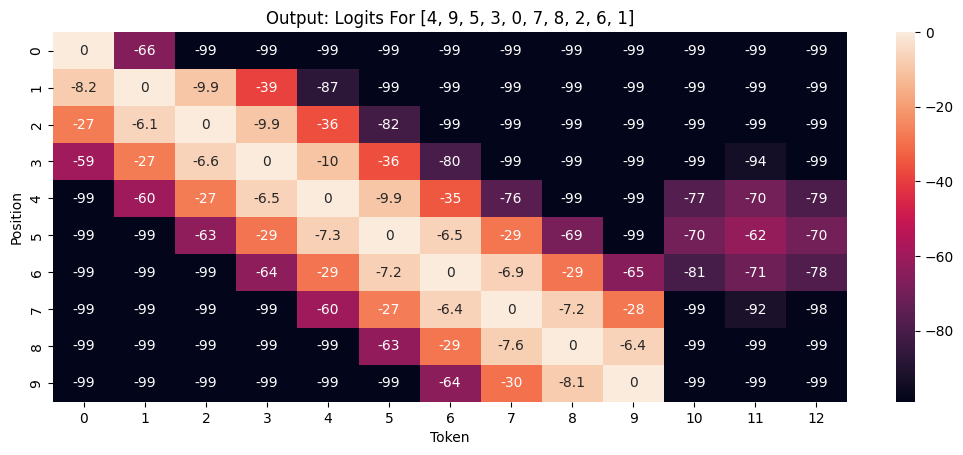

In [54]:
import random 

inp = list(range(10))
random.shuffle(inp)

visualize_output_and_attention(cfg, gen_example_from(cfg, inp), figsize=(12.8, 4.8))

tensor([10,  0,  3,  7,  5,  2,  9,  2,  7,  4,  7, 11]) tensor([10,  0,  2,  2,  3,  4,  5,  7,  7,  7,  9, 11])
unsorted_sequence tensor([0, 3, 7, 5, 2, 9, 2, 7, 4, 7])
sorted_sequence tensor([0, 2, 2, 3, 4, 5, 7, 7, 7, 9])
figsize = (12.8, 4.8)


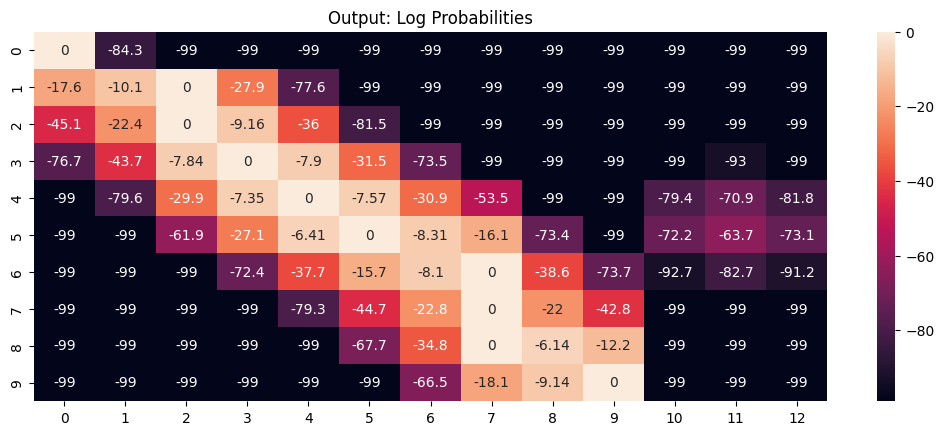

In [25]:
visualize_output_and_attention(cfg, gen_data(1, cfg), figsize=(12.8, 4.8))

#### Permutation

(tensor([[10,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 12]]), tensor([[10,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 12]]))
tensor([10,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 12]) tensor([10,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 12])
unsorted_sequence tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12])
sorted_sequence tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12])
figsize = (6.4, 4.8)


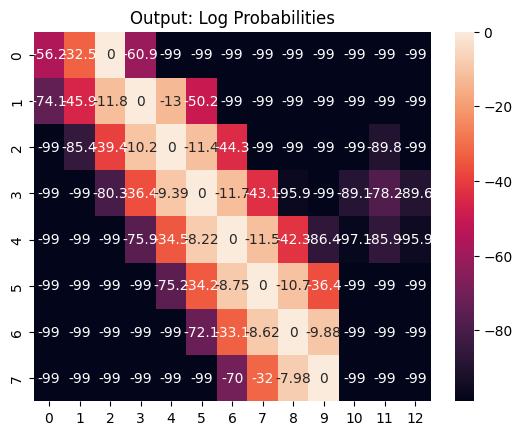

In [26]:
inp = list(range(2, 10))
# random.shuffle(inp)
example = gen_example_from(cfg, inp)
print(example)

visualize_output_and_attention(cfg, example)

### Adversarial

tensor([10,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, 11]) tensor([10,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, 11])
unsorted_sequence tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
sorted_sequence tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
figsize = (6.4, 4.8)


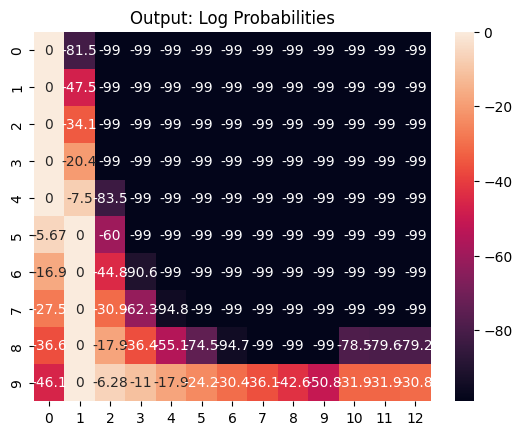

In [27]:
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 15)
# visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*5 + [1]*5), 16)
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5 + [3] + [7]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*6 + [7]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0] + [1]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]*5 + [7]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,8,8,8,8,8,8,8,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,0,0,0,0,0,0,0,8,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,5,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,1,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1,1,1,1,5,5,9,9,9,9]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*9+[1]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*1+[0]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[9]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*6+[0]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*5+[1]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[1]*6))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*1+[1]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [2]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [3]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[5]+[6]+[9]*4))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5]+[0]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [8,9,9]+[0]*7))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*9+[0]))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [4]*5+[5]*5))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*8+[9]*2))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*10))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[8]*9))
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]+[9]*9))

## Logit Attributions

In [28]:
def make_use_attn_result():
    nmodel = make_transformer(cfg)
    nmodel.load_state_dict(model.state_dict())
    model = nmodel
    print(model.cfg.use_attn_result)

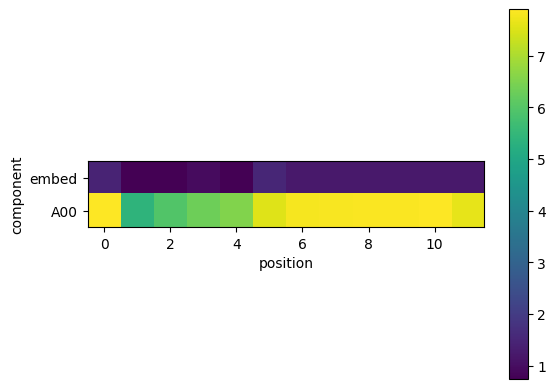

In [29]:
def visualize_logit_attributions_many(cfg: Config, sample_data):
    with t.inference_mode():
        out, cache = model.run_with_cache(sample_data)
        resid_components = [cache["embed"]]
        labels = ["embed"]
        for head in range(cfg.num_heads):
            resid_components.append(cache["result", 0][:, :, head])
            labels.append(f"A0{head}")
            
        # for component in resid_components:
        #     print(component.shape)
        
        model.cfg.use_attn_result = True
        resid_stack = torch.stack(resid_components, 0)
        resid_stack = resid_stack - resid_stack.mean(-1, keepdim=True)
        # print(resid_stack.shape)

        batch_index = 0
        logit_components = resid_stack[:, batch_index] @ model.W_U
        # print(logit_components.shape)

        logit_components = logit_components - logit_components.mean(-1, keepdim=True)
        # print(logit_components.shape)

        plt.imshow(t.log(t.linalg.norm(logit_components, dim=-1).cpu()))
        
        plt.yticks(range(len(labels)), labels)
        plt.ylabel("component")
        plt.xlabel("position")
        plt.colorbar()
        # line(logit_components[:, torch.arange(1, model.cfg.n_ctx).cuda(), tokens[:-1]].T, line_labels=labels)
        # print(cache)
        # print(cache["embed"].shape)
        # print(cache["attn_out", 0].shape)
        # print(cache["mlp_out", 0].shape)

        # print((cache["embed"][0,0] + cache["attn_out", 0][0,0] + cache["mlp_out", 0][0,0]) @ model.W_U)
        # print(out[0, 0])

        # print(model.W_U.shape)
        # model.W_U @ 
        # print(out.shape, out[0])
        # resid_components = [cache["embed"], cache["attn_out", 0], cache["mlp_out", 0], cache["attn_out", 1], cache["mlp_out", 1]]
        # attention_pattern = t.mean(cache["pattern", 0, "attn"],dim=0)
        # html = cv.attention.attention_heads(tokens=[item_to_string(cfg, x) for x in sample_data[0]], attention=attention_pattern)
        # return html
    
data = gen_data(1000, cfg)
if cfg.bidirectional:
    data = data[0]
visualize_logit_attributions_many(cfg, data)

### QK and OV Matrices

#### QK (Position)

As expected, for a fixed query position, it pays approximately equal attention to the keys correpsonding to positions 1 through 10.

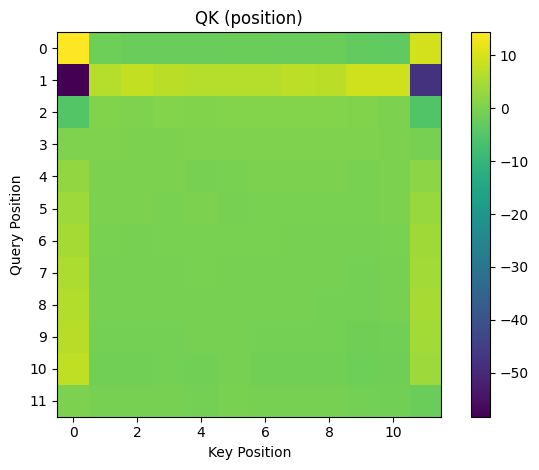

In [30]:
def display_qk_pos():
    with t.inference_mode():
        QK = model.W_pos @ model.W_Q[0, 0] @ model.W_K[0, 0].T @ model.W_pos.T
        plt.title("QK (position)")
        plt.imshow(QK.cpu())
        plt.colorbar()
        plt.ylabel("Query Position")
        plt.xlabel("Key Position")
        plt.yticks(range(QK.shape[0]))
        plt.tight_layout()

display_qk_pos()

### OV

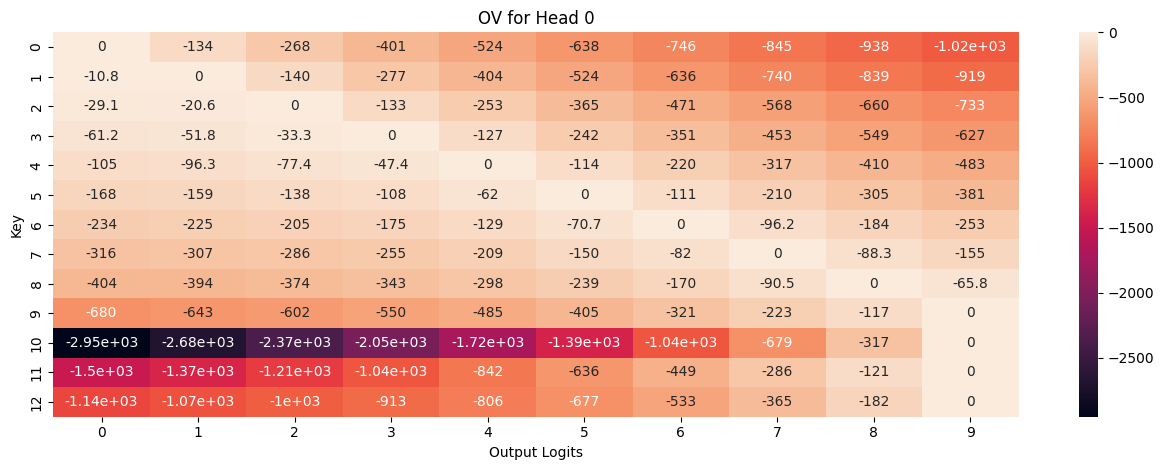

In [31]:
def display_ov():
    with t.inference_mode():
        for head in range(cfg.num_heads):
            key_embeds = model.W_E.clone()
            key_embeds[10] += model.W_pos[0] # BEG
            OV = key_embeds @ model.W_V[0, head] @ model.W_O[0, head] @ model.W_U
            OV -= OV.amax(dim=-1,keepdim=True)
            if not cfg.bidirectional:
                OV = OV[:cfg.distinct_nums+1, :cfg.distinct_nums]
            else:
                OV = OV[:, :cfg.distinct_nums]

            # fig, ax = plt.subplots()
            plt.figure(figsize=(12.8, 4.8))
            plt.title(f"OV for Head {head}")
            # if show_heatmap:
            #     heatmap(OV.cpu(), ax=ax)
            # else:
            heatmap(OV.cpu(), clip=9999)
            # plt.imshow(OV.cpu())
            # plt.colorbar()
            plt.ylabel("Key")
            plt.xlabel("Output Logits")
            plt.tight_layout()

display_ov()

- For input vocab 0-4: max is on the diagonal, dropoff to right is very steep, dropoff to left isn't as steep
- For input vocab 5-9, dropoff to left is steeper
- For input vocab 10, max is at 5, dropoff on both sides is steep

In [32]:
import torch as t

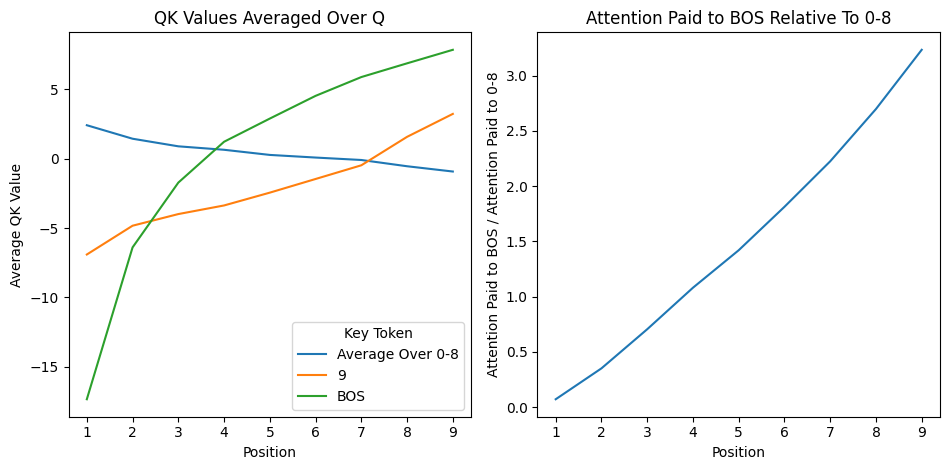

In [86]:
def plot_qk_line():
    with t.inference_mode():
        avg_0_through_8 = []
        avg_bos = []
        avg_0 = []
        avg_9 = []
        single = [[] for _ in range(10)]
        fig, ax = plt.subplots(1, 2, figsize=(9.6, 4.8))
        for pos in range(1, 10):
            embeds = model.W_E.clone()
            if pos is not None:
                if cfg.bidirectional:
                    embeds += model.W_pos[1 + pos]
                else:
                    embeds += model.W_pos[11 + pos] # 11 is MID
            key_embeds = model.W_E.clone()
            key_embeds[cfg.distinct_nums] += model.W_pos[0] # BOS is always at position 0
            for head in range(cfg.num_heads):
                QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (key_embeds @ model.W_K[0, head] + model.b_K[0, head]).T
                avg_0_through_8.append(QK[:10, :9].mean().item())
                for i in range(10):
                    single[i].append(QK[:10, i].mean().item())
                avg_bos.append(QK[:10, 10].mean().item())
        
        ax[0].plot(range(1, 10), avg_0_through_8, label="Average Over 0-8")
        for i in range(9, 10):
            ax[0].plot(range(1, 10), single[i], label=f"{i}")
        ax[0].plot(range(1, 10), avg_bos, label="BOS")
        ax[0].legend(title="Key Token")
        ax[0].set_title("QK Values Averaged Over Q")
        ax[0].set_xlabel("Position")
        ax[0].set_ylabel("Average QK Value")
        ax[1].set_title("Attention Paid to BOS Relative To 0-8")
        ax[1].plot(range(1,10), np.exp((np.array(avg_bos)-np.array(avg_0_through_8))/np.sqrt(cfg.d_model)), label="exp((BOS - Avg(0-8))/sqrt(56))")
        ax[1].set_xlabel("Position")
        ax[1].set_ylabel("Attention Paid to BOS / Attention Paid to 0-8")
        plt.tight_layout()

plot_qk_line()

In [59]:
def plot_qk_for_out(pos: Optional[int] = None):
    """pos: position you are trying to predict"""
    with t.inference_mode():
        embeds = model.W_E.clone()
        if pos is not None:
            if cfg.bidirectional:
                embeds += model.W_pos[1 + pos]
            else:
                embeds += model.W_pos[11 + pos] # 11 is MID
        fig, ax = plt.subplots(1,cfg.num_heads,figsize=(9.6, 4.8), squeeze=False)
        ax = ax[0]
        key_embeds = model.W_E.clone()
        key_embeds[cfg.distinct_nums] += model.W_pos[0] # BOS is always at position 0
        for head in range(cfg.num_heads):
            QK = (embeds @ model.W_Q[0, head] + model.b_Q[0, head]) @ (key_embeds @ model.W_K[0, head] + model.b_K[0, head]).T
            title = f"QK For Query Position {pos}"
            if pos is None:
                title = f"QK Head {head}"
            ax[head].set_title(title)
            if not cfg.bidirectional:
                QK = QK[:10, :11]
            else:
                QK = QK[:cfg.distinct_nums]
            xticklabels = [str(i) for i in range(10)]
            xticklabels.append("BOS")
            xticklabels.append("EOS")
            xticklabels.append("PAD")
            heatmap(QK.cpu(), subtract_max=False, ax=ax[head], xticklabels=xticklabels, prec=2)
            ax[head].set_ylabel("Query Token")
            ax[head].set_xlabel("Key Token")
        plt.tight_layout()

# def compute_logits(example, pos_at):
#     with t.inference_mode():
#         out, cache = model.run_with_cache(example)
#         embeds = model.W_E[example].squeeze()
#         max_dif(embeds, cache['embed'].squeeze())
#         pos_embeds = model.W_pos[t.arange(example.shape[0])].squeeze()
#         max_dif(pos_embeds, cache['pos_embed'].squeeze())
#         resids = embeds + pos_embeds
#         Q = resids @ model.W_Q[0, 0] + model.b_Q[0, 0]
#         K = resids @ model.W_K[0, 0] + model.b_K[0, 0]
#         print(Q[0])
#         print(cache['q', 0, 0].squeeze()[0])
#         assert False
#         row = (Q @ K.T)[pos_at]
#         row[pos_at:] = -10000
#         row -= row.max()
#         print(t.exp(row))
#         # print(Q.shape, K.shape)

# compute_logits(gen_example_from(cfg, [0]+[2]+[7]*8), 12)

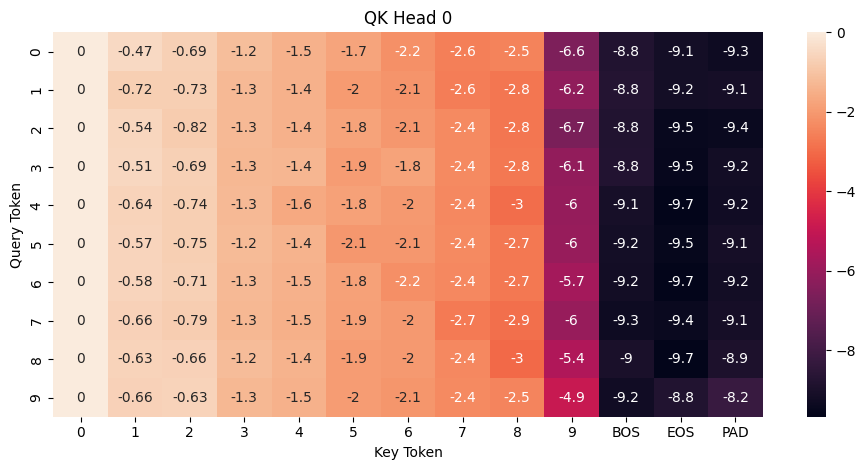

In [50]:
plot_qk_for_out()

Unidirectional:
- attention patterns for values 0-4 all look similar
- 5-9 are different

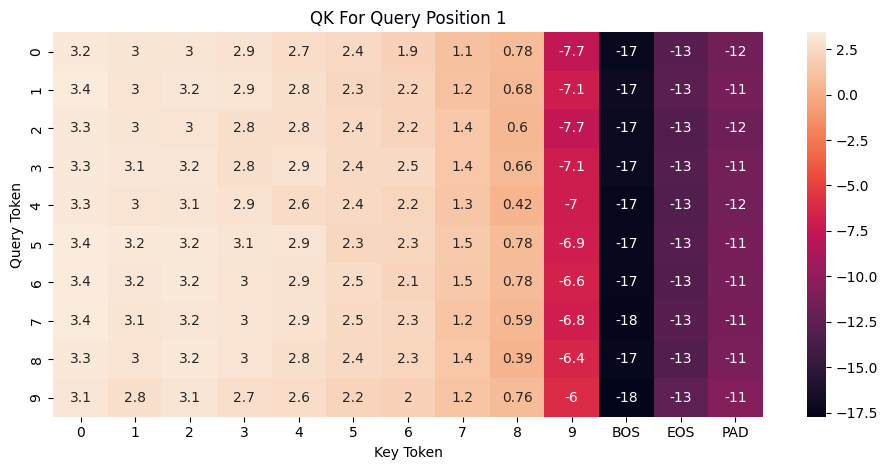

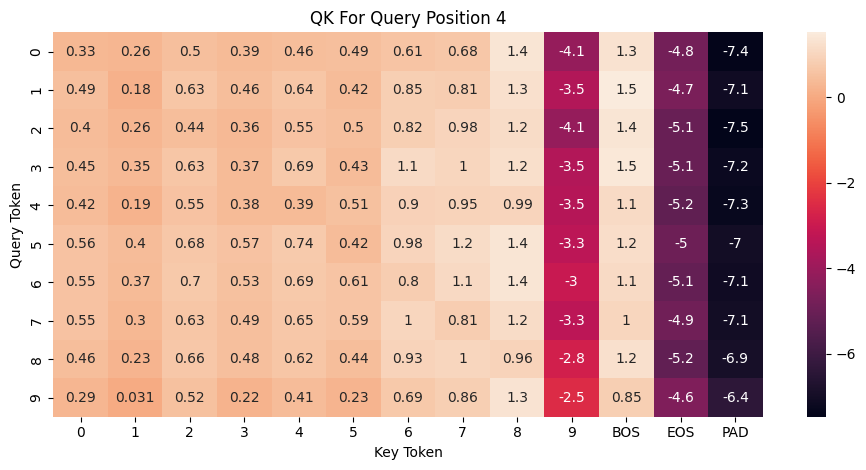

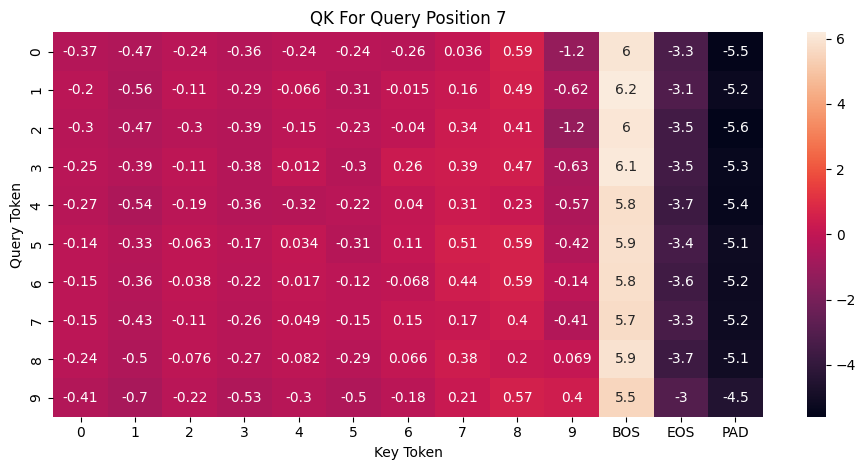

In [60]:
for pos in [1,4,7]:
    plot_qk_for_out(pos)

In [36]:
visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*4+[4]*6), 3, [0,4])

TypeError: argument "sample_data" must be of type TensorType['s'], got type tuple instead.

In [ ]:
visualize_output_by_input_pos(cfg, gen_example_from(cfg, [0]*4+[4]*6), 4, [0,4])

In [ ]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*4+[4]*6))

In [ ]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[1]*3))

In [ ]:
visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[3]+[8]*2))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[3]+[8]*2))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[1]+[7]*2))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[3]+[7]*2))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*4+[7]+[9]*5))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [1]*4+[7]+[8]*5))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,8]+[9]*8))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0,7]+[8]*8))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [5,5,5,8]+[9]*6))


In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0]*7+[3]+[4,4]))

In [ ]:
# QK for position 14
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 0, 5] + [7]*6))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 0, 6] + [7]*7))

In [ ]:
def max_dif(a: t.Tensor, b: t.Tensor):
    assert a.shape == b.shape, f"found different shapes {a.shape} {b.shape}"
    print("max_dif =", t.max(t.abs(a-b)))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 6] + [7]*8))

In [ ]:
# visualize_output_and_attention(cfg, gen_example_from(cfg, [0, 5] + [9]*8))

In [ ]:
with t.inference_mode():
    plt.title("Embedding Directions")
    embedding_vectors = model.W_E.clone()
    embedding_vectors /= t.linalg.norm(embedding_vectors, dim=-1, keepdim=True)
    plt.imshow((embedding_vectors @ embedding_vectors.T).cpu())
    plt.colorbar()

In [ ]:
%matplotlib inline
with torch.inference_mode():
    es=[]
    for tt in range(13):
        emb=model.W_E[tt]
        if tt<10:
            # emb=emb+model.W_pos[1]
            pass
        elif tt==10: # BOS
            emb=emb+model.W_pos[0]
        s=emb@model.W_V+model.b_V
        s=s@model.W_O+model.b_O
        s=s.squeeze()
        s=s@model.W_U+model.b_U
        es.append(s.tolist())

    fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
    for label in range(2):
        inputs = "0-9"
        if label == 1:
            inputs = "BOS"
        ax[label].set_title(f"OV Circuit ({inputs})")
        ax[label].set_xlabel("Output Token")
        ax[label].set_ylabel("Logits")
        if label == 0:
            for tt in range(10):
                ax[label].plot(es[tt][:10],label=str(tt))
        else:
            for tt in range(10,11):
                ax[label].plot(es[tt][:10],label=item_to_string(cfg, t.tensor([tt])))
        ax[label].legend(title="Input Token")
    plt.show()

    # es=torch.tensor(es)
    # plt.figure(figsize=(10,8))
    # sns.heatmap(es, cmap="YlGnBu", annot=True, fmt=".1f")
    # plt.show()
    # es=torch.softmax(es, dim=-1)
    # sns.heatmap(es, cmap="YlGnBu")

## Hypothesis 1

The model is implementing something like the following function:

```py
def element_at_pos(s: set, prev_val: int, pos: int):
    if s.count_greater_than(prev_val) >= len(s) - pos: 
        # ^ note: the above inequality cannot be strict
        return s.get_min_greater_than(prev_val)
        # ^ this can easily be obtained assuming transformer only pays attention to tokens with value > prev_val
        # a token increases the logit corresponding to its value. tokens with lower values result in higher increases
    else:
        return prev_val
```

Equivalently:

```
out_val =
BIG * (# >= val) + val if val > prev_val
BIG * (len(s) - pos) + val if val <= prev_val
```

but the transformer looks like:

```
BIG * f(# >= val / (# >= prev_val + smth depending on pos and prev_val)) + val if val >= prev_val
+ BIG * f((smth depending on pos and prev_val) / (# >= prev_val + smth depending on pos and prev_val)) + val for val = prev_val
```

What we know:
 - Transformer filters out everything `< prev_val`.
 - Transformer does pay attention to things with value equal to `prev_val` (why?).

## Hypothesis 2: $n$-th element selector

Probabilities just look like 

```
softmax(pos * (some fixed emb) + sum(input embeddings))
```

^ this should be doable with a single bidirectional layer

### Generalizing

When the sequence has variable length we should be able to do 

```
softmax(pos_current * (some fixed emb) + sum(input embeddings))
```

^ easy to do with a single bidirectional layer?

WRONG:

Actually, to predict the next token in the output sequence, we only need a linear layer taking as input:
 - sum of the embeddings for each value in the input sequence
 - embedding of the previous value in the output sequence
 - embedding of the current position

In [ ]:
# from sklearn.decomposition import PCA
# pcaer = PCA(n_components=10)
# pcas=pcaer.fit_transform(model.W_E.T.detach().cpu().numpy())


# fig, ax = plt.subplots()
# z=pcas[:10,2]
# y=pcas[:10,1]
# ax.scatter(z, y)

# for i in range(len(z)):
#     ax.annotate(str(i), (z[i], y[i]))

# Summary

## Models

We considered one-layer attention-only models with a single head without any 
normalization, both causal and bidirectional.

## Tasks

### Causal Model

Input: a list of $10$ integers $a_0,\dots,a_9$ where each $a_i$ is in the range $[0,9]$.

```
Input Format:  BEG a_0 a_1 ... a_9 MID         sorted(a)_0 sorted(a)_1 ... sorted(a)_9
Output Format: ?   ?   ?   ... ?   sorted(a)_0 sorted(a)_1 sorted(a)_2 ... ?
```

Here, ? means that we ignore the model's output for that position.

### Bidirectional Model

Input: a list of integers $a_0,\dots,a_{n-1}$ where each $a_i$ is in the range $[0,9]$ and $1\le n\le 10$.

```
Input Format:  `BEG a_0 a_1 ... a_{n-1} END PAD PAD ...`
Output Format: `? sorted(a)_0 sorted(a)_1 ... sorted(a)_{n-1} ? ...`
```

## Training Data

We chose $n$ uniformly at random from $1$ to $10$ for the bidirectional model 
and fixed $n=10$ for the causal model. We initially tried generating all the
inputs uniformly in the range $[0,9]$, but we found that the resulting model
performed poorly on inputs such as `0 0 0 0 0 1 1 1 1 1`. So instead we first
selected $p\in(0,1)$ uniformly, constructed a set `s` containing each of the 
integers from $0$ to $9$ independently with probability $p$, and then generated
the input by sampling from `s` $n$ times. (Caveat: if `s` is empty then we 
restart the process.)

## Training

We used cross-entropy loss, and Adam with the default parameters. Trained for
5000 epochs.

## Results (Bidirectional)

Average loss 0.0003 by the end of training. 

Evidence: OV and QK circuits (TODO)

## Results (Causal)

Average loss 0.02 by the end of training. 

Notes: It was surprising that the loss was higher despite being given an 
"easier" task. We were able to achieve loss similar to that of the bidirectional
model by always using the same query vector.

Evidence: OV and QK circuits (TODO)